In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from datetime import datetime,timedelta


In [3]:
complete_orders=pd.read_csv("../data/nb.csv")
delivery_requests=pd.read_csv("../data/driver_locations_during_request.csv")

information about the completed orders

In [33]:
complete_orders.shape

(536020, 5)

In [5]:
complete_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Trip ID           536020 non-null  int64 
 1   Trip Origin       536020 non-null  object
 2   Trip Destination  536020 non-null  object
 3   Trip Start Time   534369 non-null  object
 4   Trip End Time     536019 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.4+ MB


In [44]:
percentage = round(complete_orders.nunique()*100/complete_orders.shape[0],2)
percentage_df=pd.DataFrame(percentage,columns=["Unique %"])
percentage_df.head()

,Unique %
Trip ID,100.00
Trip Origin,20.92
Trip Destination,27.52
Trip Start Time,95.62
Trip End Time,95.86


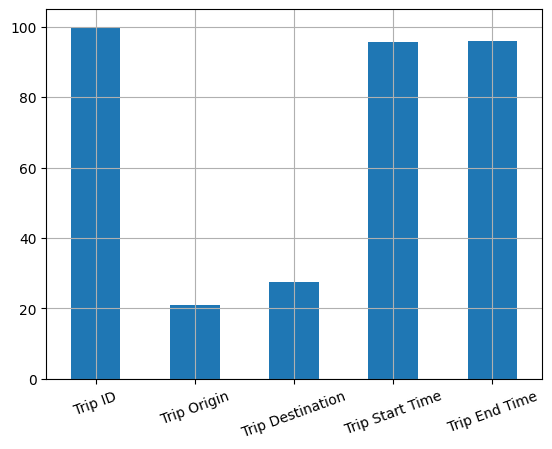

In [54]:
percentage_df.plot(kind='bar',rot=20,grid=True,legend=False)
plt.show()

In [20]:
complete_orders.isna().sum()

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          1
dtype: int64

We only have one missing value for Trip End Time, let's check if Trip Start Time is also null for that specific record

In [8]:
complete_orders[complete_orders["Trip End Time"].isna()]

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
59737,530900,"6.4971445,3.3384259","6.529695343361617,3.386906603181526",2021-07-22 19:54:15,NaN


since we have the Trip start time value, we can use average trip duration to fill the missing values (fro both start & end time)

In [4]:
# First we have to change the columns to appropriate datatype : date

def change_to_date(df:pd.DataFrame,columns:list):
    for column in columns:
        df[column] = pd.to_datetime(df[column])
    return df

In [5]:
def calculate_duration(df:pd.DataFrame,start_col_name,end_col_name):
    df["duration"]= (df[end_col_name] - df[start_col_name]).astype('timedelta64[m]')
    return df

In [6]:
complete_orders_correct_format=complete_orders.copy()
complete_orders_correct_format=change_to_date(complete_orders_correct_format,["Trip Start Time","Trip End Time"])
complete_orders_correct_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Trip ID           536020 non-null  int64         
 1   Trip Origin       536020 non-null  object        
 2   Trip Destination  536020 non-null  object        
 3   Trip Start Time   534369 non-null  datetime64[ns]
 4   Trip End Time     536019 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 20.4+ MB


In [7]:
complete_orders_correct_format=calculate_duration(complete_orders_correct_format,"Trip Start Time","Trip End Time")
complete_orders_correct_format.isna().sum()

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          1
duration            1652
dtype: int64

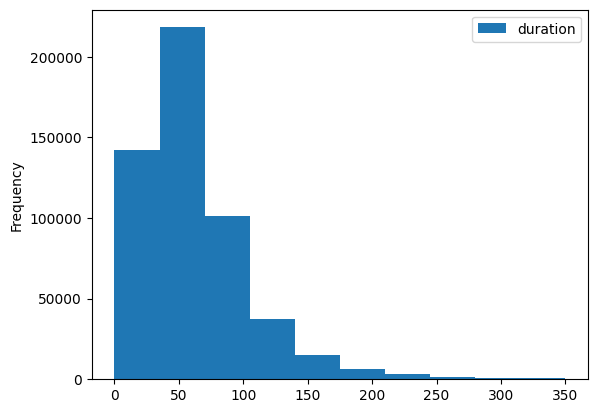

In [13]:
complete_orders_correct_format[["duration"]].plot.hist(bins=10, range=(0,350))
plt.show()

### Fill missing data

- numerical columns can be filled with either median or mean

- for numerical columns the decision to use which method will be determined by observing the skewness of the data
- When the data is skewed, it is good to consider using the median value for replacing the missing values. Note that imputing missing data with median value can only be done with numerical data.
    - checking for skew
    - 0 means No skew
    - +ve value means right skew
    - -ve value means left skew
- we have seen that duration is right skewed so we will use median

In [8]:
def fill_missing(df: pd.DataFrame, method: str,columns: list) -> pd.DataFrame:
        """
        fill missing values with specified method
        """
        if method == "mean":
            for col in columns:
                df[col].fillna(df[col].mean(), inplace=True)

        elif method == "median":
            for col in columns:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            print("Method unknown")
        
        return df

In [9]:
complete_cleaned = complete_orders_correct_format.copy()
complete_cleaned = fill_missing(complete_cleaned,"median",["duration"])
complete_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Trip ID           536020 non-null  int64         
 1   Trip Origin       536020 non-null  object        
 2   Trip Destination  536020 non-null  object        
 3   Trip Start Time   534369 non-null  datetime64[ns]
 4   Trip End Time     536019 non-null  datetime64[ns]
 5   duration          536020 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 24.5+ MB


now we have no null values in the duration

we can reverse engineer the start time and end time

In [29]:
def get_start_time(df:pd.DataFrame,start_col:str,end_col:str,duration_col):
    fill_values=  df.apply(lambda x:x[end_col] - pd.Timedelta(minutes=x[duration_col]),axis=1)
    # return fill_values
    df[start_col].fillna(fill_values,inplace=True)
    return df 

def get_end_time(df:pd.DataFrame,start_col:str,end_col:str,duration_col):
    fill_values=  df.apply(lambda x:x[start_col] + pd.Timedelta(minutes=x[duration_col]),axis=1)
    # return fill_values
    df[end_col].fillna(fill_values,inplace=True)
    return df 

In [30]:
complete_cleaned = get_start_time(complete_cleaned,"Trip Start Time","Trip End Time","duration")
complete_cleaned = get_end_time(complete_cleaned,"Trip Start Time","Trip End Time","duration")
complete_cleaned.isna().sum()

Trip ID             0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
duration            0
dtype: int64

In [31]:
complete_cleaned[complete_cleaned["Trip ID"]==530900]

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,duration
59737,530900,"6.4971445,3.3384259","6.529695343361617,3.386906603181526",2021-07-22 19:54:15,2021-07-22 20:46:15,52.0


In [8]:
complete_orders.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [36]:
print(complete_orders[complete_orders["Trip Origin"]==(0,0)].shape)
print(complete_orders[complete_orders["Trip Destination"]==(0,0)].shape)

(0, 5)
(0, 5)


## delivery request

In [9]:
delivery_requests.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN


In [60]:
# trips=list(complete_cleaned["Trip ID"])
# delivery_requests[delivery_requests["order_id"] in null_trip]
# delivery_requests[pd.DataFrame(delivery_requests.order_id.tolist()).isin(trips).any(1).values]["driver_action"].value_counts()

In [43]:
delivery_requests["driver_action"].value_counts()

rejected    1531837
accepted      25903
Name: driver_action, dtype: int64